# Entropy computation of Emanuel model

Please find the required packages dealing with compartmental systems at https://github.com/MPIBGC-TEE.

In [1]:
# general imports
import string
from sympy import solve, Matrix, symbols
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# import Emanuel model from bgc_md2 model database
from bgc_md2.models.Emanuel1981.source import mvs

# LAPM handles compartmental systems in equilibrium
from LAPM.linear_autonomous_pool_model import LinearAutonomousPoolModel as LAPM

## Load the general model structure

In [2]:
# create a smooth reservoir model from the database
srm = mvs.get_SmoothReservoirModel();

{NumericCompartmentalMatrixFunc,NumericStartValueArray,AggregatedVegetationCarbon,SmoothReservoirModel,OutFluxesBySymbol,InternalFluxesBySymbol,InFluxesBySymbol}
{InputTuple,NumericCompartmentalMatrixFunc,VegetationCarbonInternalFluxesBySymbol,OutputTuple,AggregatedVegetationCarbon,VegetationCarbonOutFluxesBySymbol,NumericStartValueArray,SmoothReservoirModel,AggregatedVegetationCarbonInFlux,VegetationCarbonInFluxesBySymbol,VegetationCarbonCompartmentalMatrix,InFluxesBySymbol,AggregatedVegetationCarbonOutFlux,NumericStartValueDict,NumericParameterizedSmoothReservoirModel,OutFluxesBySymbol,InternalFluxesBySymbol,CompartmentalMatrix}
{NumericCompartmentalMatrixFunc,VegetationCarbonInternalFluxesBySymbol,OutputTuple,AggregatedVegetationCarbon,AggregatedVegetationCarbonInFlux,VegetationCarbonInFluxesBySymbol,CompartmentalMatrix,NumericStartValueDict,OutFluxesBySymbol,InternalFluxesBySymbol,InputTuple,VegetationCarbonInputTuple,VegetationCarbonOutFluxesBySymbol,SmoothReservoirModel,Aggregate

In [3]:
B = srm.compartmental_matrix
B

Matrix([
[-F_1,    0,    0,    0,    0],
[F_21, -F_2,    0,    0,    0],
[   0,    0, -F_3,    0,    0],
[F_41, F_42, F_43, -F_4,    0],
[   0, F_52, F_53, F_54, -F_5]])

In [4]:
u = srm.external_inputs
u

Matrix([
[I_1],
[  0],
[I_3],
[  0],
[  0]])

## Plot the model

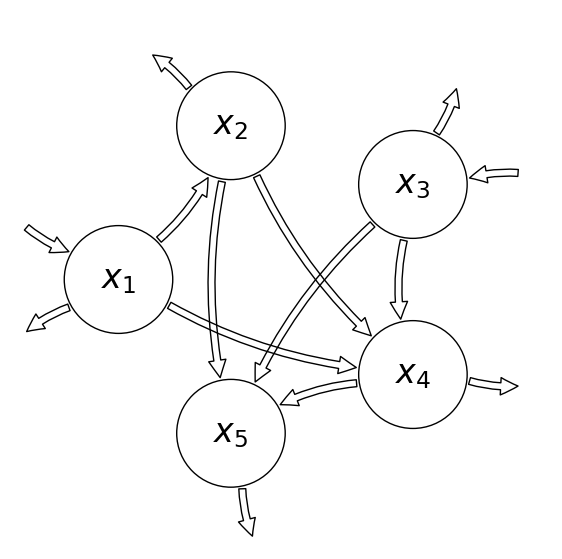

In [5]:
fig, ax = plt.subplots(figsize=(7,7))
srm.plot_pools_and_fluxes(ax, black_and_white=True, legend=False)

## Provide pool names and parameter values

In [6]:
pool_names = ["nonwoody tree parts", "woody tree parts", "ground vegetation", "detritus/composers", "active soil carbon"]

In [7]:
par_dict = {
    "I_1": 77,
    "I_3": 36,
    "F_1": 77/36.,
    "F_21": 31/37., "F_2": 31/452.,
    "F_3": 36/69.,
    "F_41": 21/37., "F_42": 15/452., "F_43": 12/69., "F_4": 48/81.,
    "F_52": 2/452., "F_53": 6/69., "F_54": 3/81., "F_5": 11/1121.
}

In [8]:
# compartmental matrix
B.subs(par_dict)

Matrix([
[-2.13888888888889,                   0,                  0,                  0,                    0],
[0.837837837837838, -0.0685840707964602,                  0,                  0,                    0],
[                0,                   0, -0.521739130434783,                  0,                    0],
[0.567567567567568,  0.0331858407079646,  0.173913043478261, -0.592592592592593,                    0],
[                0, 0.00442477876106195, 0.0869565217391304,  0.037037037037037, -0.00981266726137377]])

In [9]:
# external input vector
u.subs(par_dict)

Matrix([
[77],
[ 0],
[36],
[ 0],
[ 0]])

## Prepare and run the computations in dependence of the environmental rate modifier

In [10]:
# environmental rate modifier
xi = symbols("xi")
xis = np.arange(0.1, 8, 0.05)

In [11]:
def create_modified_Emanuel_model(xi):
    """Create model in equilibrium dependent on ``xi``."""
    par_dict_extended = par_dict.copy()
    par_dict_extended["xi"] = xi
    B_modified = xi * B
    
    return LAPM(u.subs(par_dict_extended), B_modified.subs(par_dict_extended), force_numerical=True)

In [12]:
%%time

# compute model properties dependent of ``xi``
thetas, ETs, path_entropies, ENs, theta_Ns, xsss, exp_Hs, theta_discs, theta_conts = [], [], [], [], [], [], [], [], []
for xi in xis:
    # linea autonomous pool model (LAPM)
    model = create_modified_Emanuel_model(xi)
    
    # steady state
    xsss.append(np.array(model.xss).reshape(-1))
    
    # entropy rate per unit time
    theta = float(model.entropy_rate)
    thetas.append(theta)

    # mean transit time
    ET = model.T_expected_value
    ETs.append(ET)

    # path entropy
    path_entropies.append(model.entropy_per_cycle)
    
    # mean number of jumps
    EN = model.absorbing_jump_chain.expected_number_of_jumps+1
    ENs.append(EN)
    
    # entropy rate per jump
    theta_N = model.entropy_per_jump
    theta_Ns.append(theta_N)

    # discrete part of entropy rate per unit time
    theta_disc = model.ergodic_jump_chain.ergodic_entropy * EN / ET
    theta_discs.append(float(theta_disc))

    # continuous part of entropy rate per unit time
    theta_conts.append(theta - theta_disc)  

    # one-pool entropy
    lamda = float(1/ET)
    exp_Hs.append(1 - np.log(lamda))

CPU times: user 1min 57s, sys: 0 ns, total: 1min 57s
Wall time: 1min 57s


## Make the entropy plots

In [35]:
# set plot parameters

mpl.rcParams['lines.linewidth'] = 4

SMALL_SIZE = 26
MEDIUM_SIZE = 30
#BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE, frameon=True)    # legend fontsize
#plt.rc('legend', fontsize=SMALL_SIZE, frameon=False)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

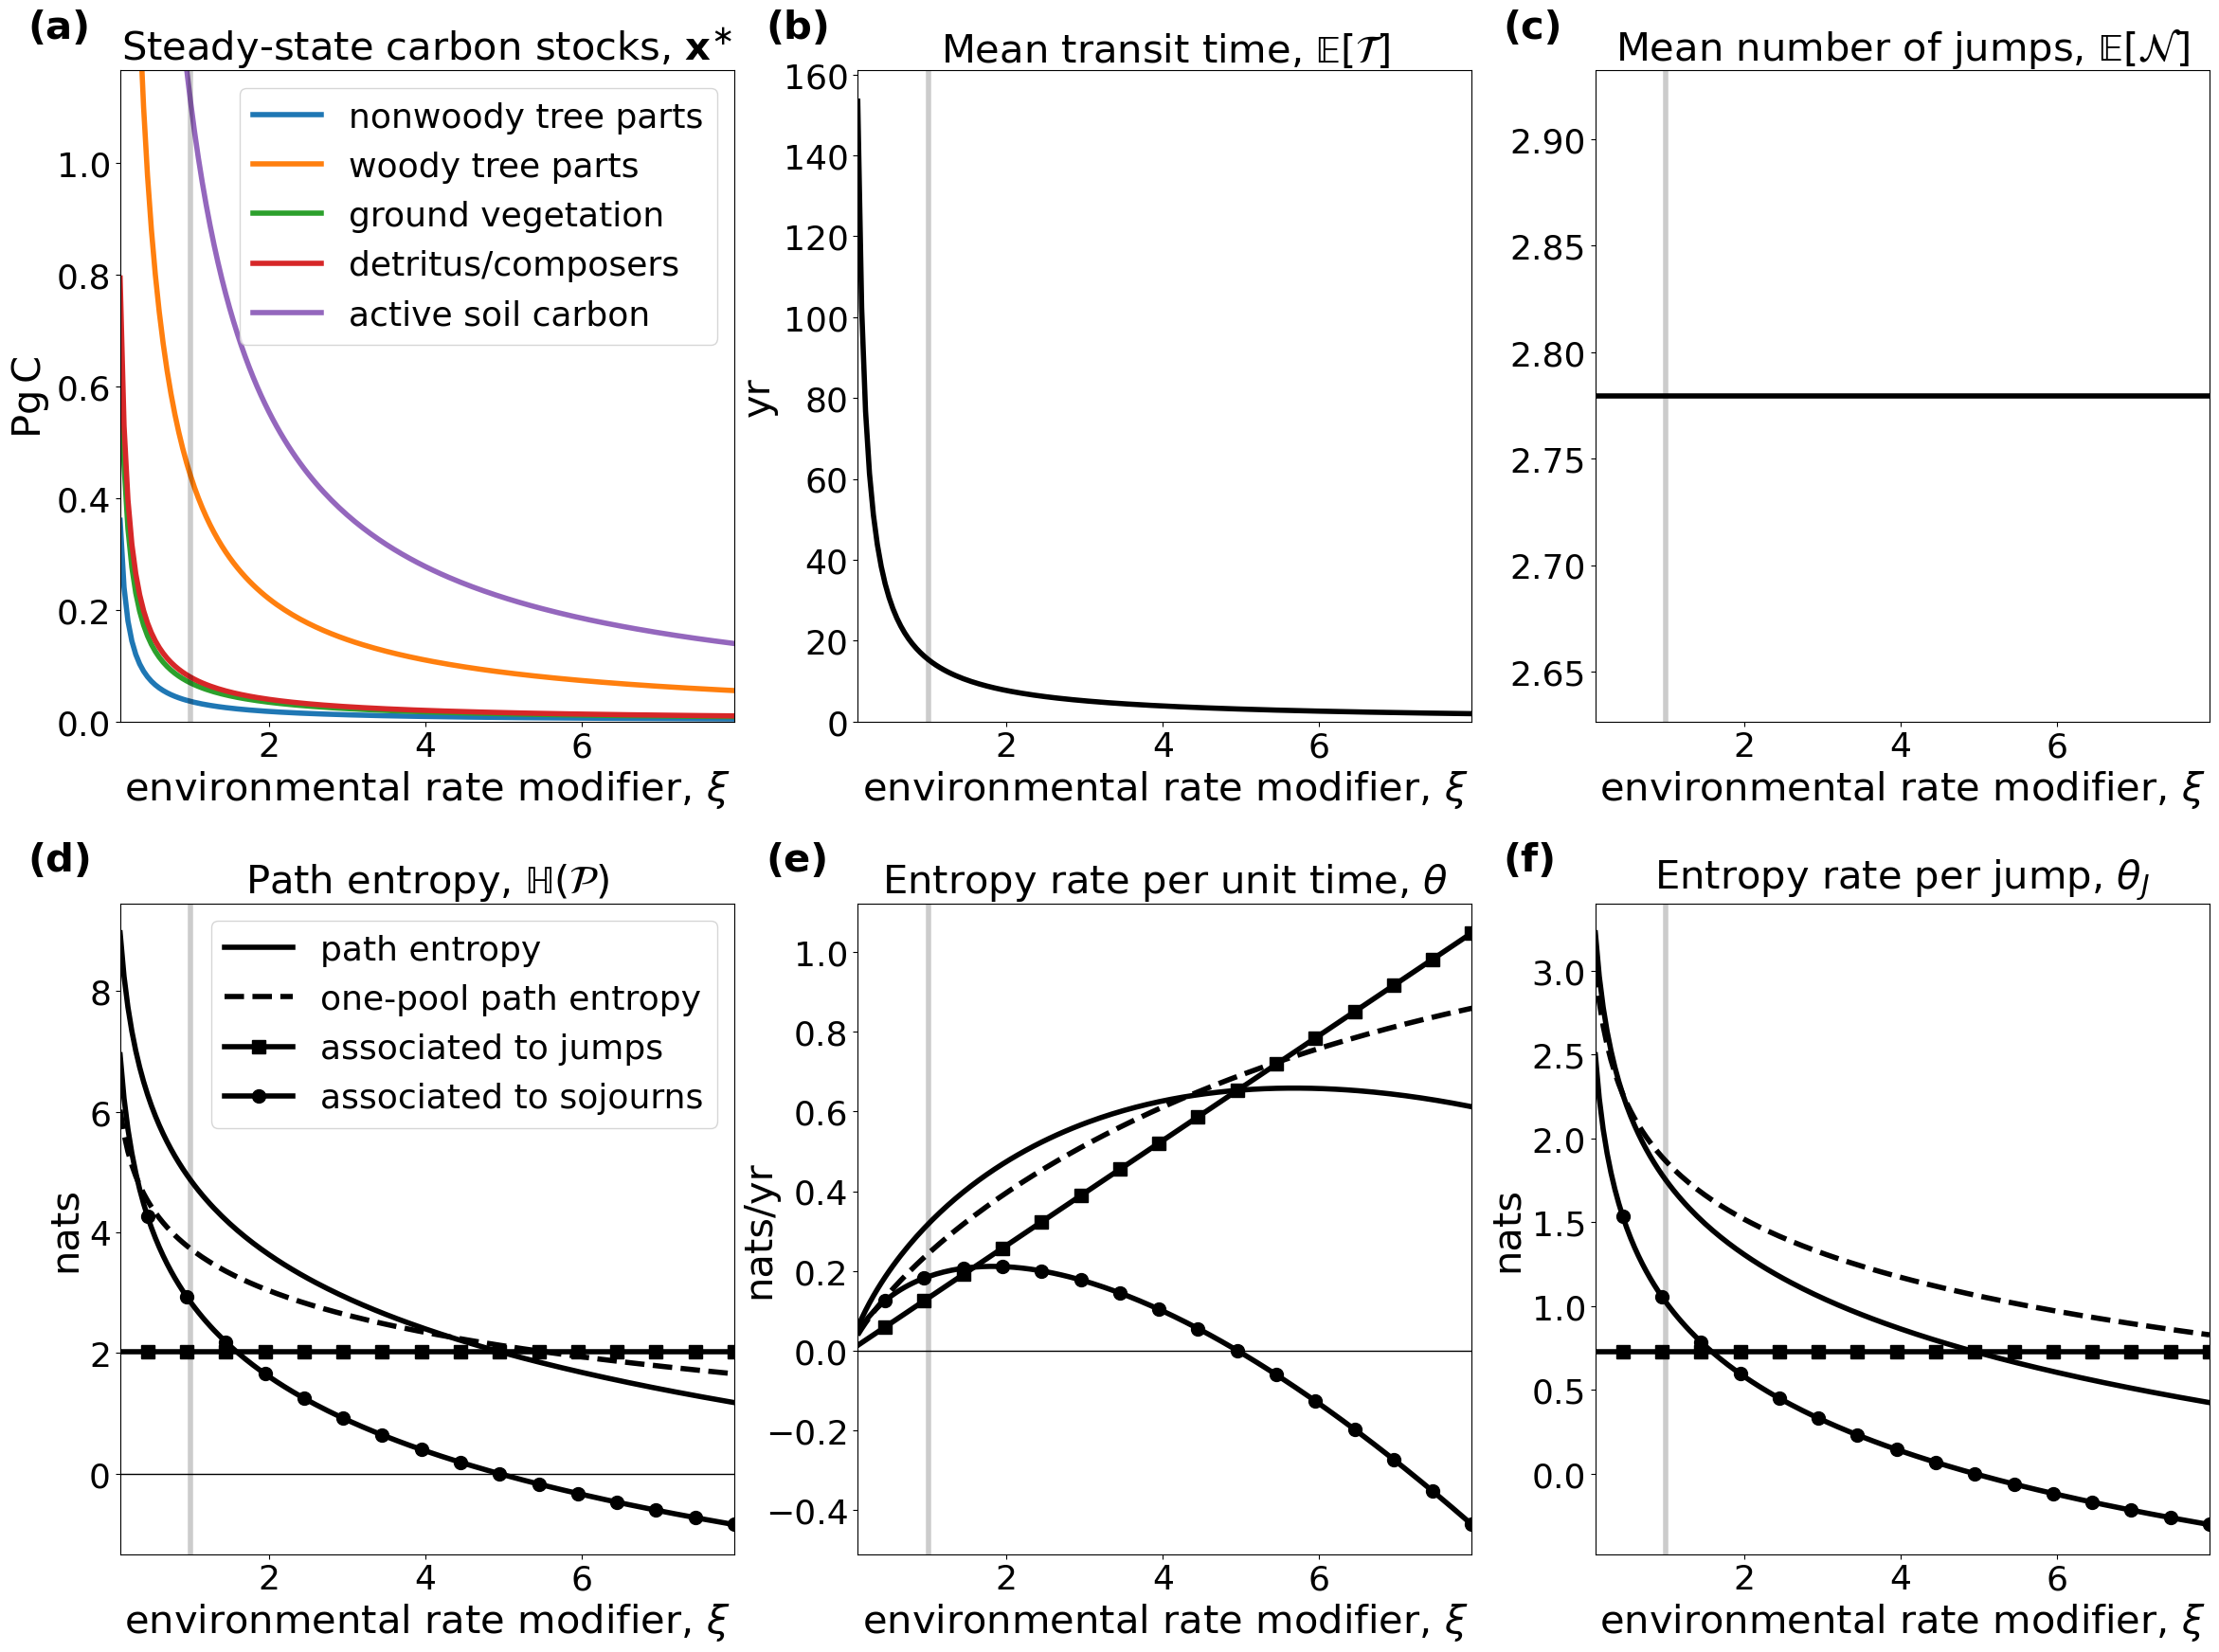

In [36]:
fig, axes = plt.subplots(figsize=(8*3, 6*3), nrows=2, ncols=3)
axes_list = axes.flatten()
panel_names = iter(string.ascii_lowercase[:len(axes_list)])
[ax.set_xlabel(r"environmental rate modifier, $\xi$") for ax in axes_list]

axes = iter(axes_list)

ax = next(axes)
ax.set_title(r"Steady-state carbon stocks, $\mathbf{x}^{\ast}$")
lines = ax.plot(xis, np.array(xsss)*1e-03)
ax.legend(lines, pool_names)
ax.set_ylim([0, ax.get_ylim()[1]/10])
ax.set_ylabel("Pg$\,$C")


ax = next(axes)
ax.set_title(r"Mean transit time, $\mathrm{\mathbb{E}}\left[\mathcal{T}\right]$")
ax.plot(xis, ETs, c="black")
ax.set_ylim([np.maximum(0, ax.get_ylim()[0]), ax.get_ylim()[1]])
ax.set_ylabel("yr")


ax = next(axes)
ax.set_title(r"Mean number of jumps, $\mathrm{\mathbb{E}}\left[\mathcal{N}\right]$")
ax.plot(xis, ENs, c="black")
ax.set_ylim([np.maximum(0, ax.get_ylim()[0]), ax.get_ylim()[1]])


ax = next(axes)
ax.set_title(r"Path entropy, $\mathrm{\mathbb{H}}(\mathcal{P})$")
ax.plot(xis, path_entropies, label="path entropy", c="black")
ax.plot(xis, exp_Hs, label="one-pool path entropy", c="black", ls="--")

ax.plot(xis, np.array(theta_discs)*np.array(ETs), label="associated to jumps", c="black", marker="s", markevery=np.arange(len(xis))[-1::-10], markersize=10)
ax.plot(xis, np.array(theta_conts)*np.array(ETs), label="associated to sojourns", c="black", marker="o", markevery=np.arange(len(xis))[-1::-10], markersize=10)
ax.axhline(0, c="black", lw=1)

ax.legend()
ax.set_ylabel("nats")


ax = next(axes)
ax.set_title(r"Entropy rate per unit time, $\theta$")
ax.plot(xis, thetas, label="entropy rate", c="black")
ax.plot(xis, np.array(exp_Hs)/np.array(ETs), label="one-pool entropy rate", c="black", ls="--")

ax.plot(xis, theta_discs, label="associated to jumps", c="black", marker="s", markevery=np.arange(len(xis))[-1::-10], markersize=10)
ax.plot(xis, theta_conts, label="associated to sojourns", c="black", marker="o", markevery=np.arange(len(xis))[-1::-10], markersize=10)
ax.axhline(0, c="black", lw=1)

#ax.legend()
ax.set_ylabel("nats/yr", labelpad=-10)


ax = next(axes)
ax.set_title(r"Entropy rate per jump, $\theta_J$")
ax.plot(xis, theta_Ns, c="black", label="entropy rate")
ax.plot(xis, np.array(exp_Hs)/2, label="one-pool entropy rate", c="black", ls="--")

ax.plot(xis, np.array(theta_discs)*np.array(ETs)/np.array(ENs), label="associated to jumps", c="black", marker="s", markevery=np.arange(len(xis))[-1::-10], markersize=10)
ax.plot(xis, np.array(theta_conts)*np.array(ETs)/np.array(ENs), label="associated to sojourns", c="black", marker="o", markevery=np.arange(len(xis))[-1::-10], markersize=10)
ax.set_ylabel("nats")
#ax.legend()


for ax, panel_name in zip(axes_list, panel_names):
    ax.set_xlim([min(xis), max(xis)])
    ax.axvline(1, color="black", alpha=0.2)
    ax.text(-0.15, 1.05, f"({panel_name})", transform=ax.transAxes, size=MEDIUM_SIZE, weight='bold')
    
fig.tight_layout(w_pad=-0.6, h_pad=1.0)

## Identification of intersection

Find out for which `xi` the one-pool model entropy and the mutli-pool model entropy coincide.

In [15]:
from scipy.optimize import root

In [16]:
def g(xi):
    """Auxiliary function for root solve."""
    # equilibrium model dependent on xi
    model = create_modified_Emanuel_model(float(xi))

    # mean transit time and rate parameter
    ET = float(model.T_expected_value)
    lamda = 1 / ET
    
    # path entropy multi-pool model
    HP = model.entropy_per_cycle

    # difference of path entropy of multi-pool model and one-pool entropy
    return HP - (1 - np.log(lamda))

In [17]:
# find intersection xi using arbitrary initial value
root(g, 4.0)

 message: The solution converged.
 success: True
  status: 1
     fun: -1.9470825064761978e-15
       x: [ 4.311e+00]
    nfev: 7
    fjac: [[-1.000e+00]]
       r: [ 1.808e-01]
     qtf: [-4.921e-12]